In [1]:
import sys
import os
import rasterio

module_path = os.path.abspath(os.path.join('/workspace/Transformer_OD_TPU'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "6" 

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [4]:
import argparse
import datetime
import json
import random
import time
from pathlib import Path
from tqdm import tqdm

import numpy as np
import torch
from torch.utils.data import DataLoader, DistributedSampler

import datasets
import util.misc as utils
from datasets import build_dataset, get_coco_api_from_dataset
from engine import evaluate, train_one_epoch
from models import build_model

In [5]:
import main

In [6]:
crop = 400
experiment = f'detr_output_400_binary_skip'
output_dir = os.path.join('/workspace/',experiment)
vis_dir = os.path.join('/workspace/',experiment,'val_outputs')
os.makedirs(vis_dir, exist_ok=True)

if 'binary' in (output_dir):
    sys.argv =  ['main.py', '--num_classes', '2', '--coco_path', '/workspace/processed_data/initial_data', '--num_workers', '0', '--resume', f'{output_dir}/best_checkpoint.pth', '--batch_size', '1', '--crop', f'{crop}']
else:
    sys.argv = ['main.py', '--coco_path', '/workspace/processed_data/initial_data', '--num_workers', '0', '--resume', f'{output_dir}/best_checkpoint.pth', '--batch_size', '1', '--crop', f'{crop}']


In [7]:
parser = main.get_args_parser()
args = parser.parse_args()

In [8]:
dataset_train = build_dataset(image_set='train', args=args)
dataset_val = build_dataset(image_set='val', args=args)

loading annotations into memory...
Done (t=0.16s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [9]:
sampler_train = torch.utils.data.RandomSampler(dataset_train)
sampler_val = torch.utils.data.SequentialSampler(dataset_val)

batch_sampler_train = torch.utils.data.BatchSampler(
    sampler_train, args.batch_size, drop_last=True)

data_loader_train = DataLoader(dataset_train, batch_sampler=batch_sampler_train,
                                collate_fn=utils.collate_fn, num_workers=args.num_workers)
data_loader_val = DataLoader(dataset_val, 1, sampler=sampler_val,
                            drop_last=False, collate_fn=utils.collate_fn, num_workers=args.num_workers)

In [10]:
device = torch.device(args.device)
model, criterion, postprocessors = build_model(args)
model = model.to(device).eval()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
checkpoint = torch.load(args.resume, map_location='cpu')
model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [12]:
def plot_inputs(sample):
    image = sample[0].tensors[0].cpu().numpy()[0,:,:]
    plt.figure(figsize=(6,6))
    plt.imshow(image, cmap='Greys_r')
    ax = plt.gca()
    
    input_bbox_rescale = rescale_bboxes(sample[1][0]['boxes'].to(device), image.shape)
    for (xmin, ymin, xmax, ymax) in input_bbox_rescale.tolist():
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color='g', linewidth=3))

def plot_outputs(sample, prob, boxes):
    image = sample[0].tensors[0].cpu().numpy()[0,:,:]
    plt.figure(figsize=(6,6))
    plt.imshow(image, cmap='Greys_r')
    ax = plt.gca()
    for p, (xmin, ymin, xmax, ymax) in zip(prob, boxes.tolist()):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color='r', linewidth=3))
        cl = p.argmax()
        text = f'{p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='red', alpha=0.8))
    
    input_bbox_rescale = rescale_bboxes(sample[1][0]['boxes'].to(device), image.shape)
    for (xmin, ymin, xmax, ymax) in input_bbox_rescale.tolist():
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color='g', linewidth=3))

def rescale_bboxes(out_bbox, shape):
    w, h = shape
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([w, h, w, h], dtype=torch.float32).to(device)
    return b

def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

In [13]:
# # Define the forward hook function
# def hook_fn(module, input, output):
#     class_name = module.__class__.__name__
#     module_idx = len(hook_fn.hooks)
#     print(f"{module_idx} | {class_name} | Output type: {type(output)}")

# # List to hold all hooks
# hook_fn.hooks = []

# # Register hooks on all layers
# for layer in model.modules():
#     hook = layer.register_forward_hook(hook_fn)
#     hook_fn.hooks.append(hook)

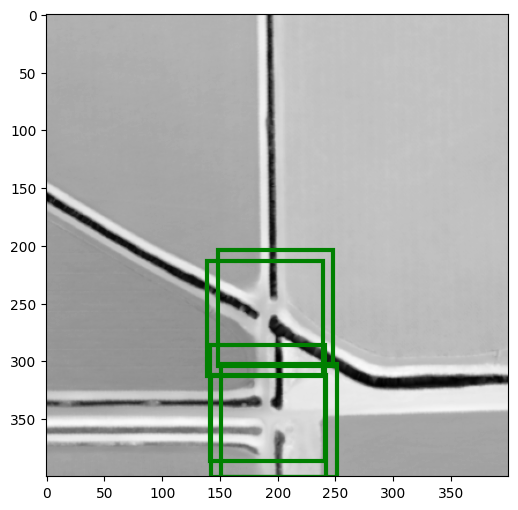

In [14]:
sample = next(iter(data_loader_val))
plot_inputs(sample)

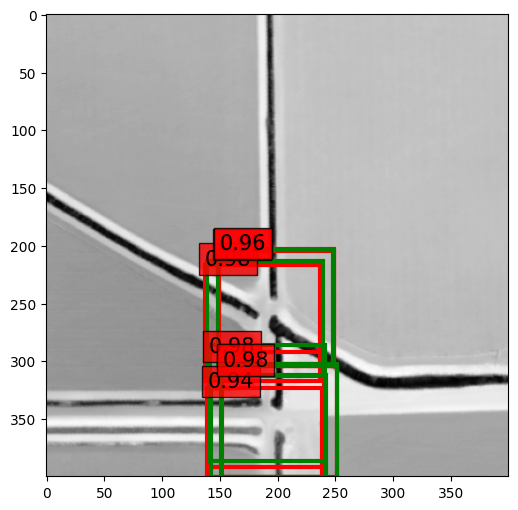

In [15]:
samples, targets = sample
samples = samples.to(device)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
outputs = model(samples)
image = sample[0].tensors[0].cpu().numpy()[0,:,:]

probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
keep = probas.max(-1).values > 0.7

# convert boxes from [0; 1] to image scales
bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], image.shape)

plot_outputs(sample, probas[keep], bboxes_scaled)

In [16]:
def plot_results(sample, prob, boxes, idx):
    image = sample[0].tensors[0].cpu().numpy()[0,:,:]
    plt.figure(figsize=(6,6))
    plt.imshow(image, cmap='Greys_r')
    ax = plt.gca()
    for p, (xmin, ymin, xmax, ymax) in zip(prob, boxes.tolist()):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color='r', linewidth=3))
        cl = p.argmax()
        text = f'{p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='red', alpha=0.8))
    
    input_bbox_rescale = rescale_bboxes(sample[1][0]['boxes'].to(device), image.shape)
    for (xmin, ymin, xmax, ymax) in input_bbox_rescale.tolist():
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color='g', linewidth=3))

    plt.savefig(os.path.join(vis_dir,f'{idx}_output.png'))
    plt.close()

def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, shape):
    w, h = shape
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([w, h, w, h], dtype=torch.float32).to(device)
    return b

In [17]:
for idx, sample in enumerate(tqdm(data_loader_val)):
    if idx % 50 != 0:
         continue
    samples, targets = sample
    samples = samples.to(device)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    outputs = model(samples)
    image = sample[0].tensors[0].cpu().numpy()[0,:,:]
    
    # keep only predictions with 0.7+ confidence
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > 0.7
    
    # convert boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], image.shape)
    
    plot_results(sample, probas[keep], bboxes_scaled, idx)

100%|█████████████████████████████████████| 372/372 [00:15<00:00, 24.15it/s]
